In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.animation as anim
from numba import jit
from tqdm import tqdm 
import time

In [2]:
# Definimos la clase particula
class Particle():
    
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt = t[1]-t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros((len(t),len(r0)))
        self.vVector = np.zeros((len(t),len(v0)))
        self.aVector = np.zeros((len(t),len(a0)))
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        self.MomentumVector = np.zeros((len(t),len(v0)))
        
        self.EpVector = np.zeros((len(t),1))
        self.EkVector = np.zeros((len(t),1))
        
        self.Ep = 0.
        
        self.Force = self.m * self.a
        
        self.K = 100
        # Initial condition
        
        
    def Evolution(self,i):
        
        # fill vectors
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        # Energy 
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        self.a = self.Force/self.m
        
        # Change variables
        
        self.r += self.dt * self.v 
        self.v += self.dt * self.a
    
    def CheckWallLimits(self, limits, dim=2):
        
        for i in range(dim):
            if self.r[i] + self.radius > limits[i] and self.v[i] > 0:
                self.v[i] = -self.v[i]
            if self.r[i] - self.radius < -limits[i] and self.v[i] < 0:
                self.v[i] = -self.v[i]
     
    def ResetForce(self):
        
        self.Force[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.
        self.Niter = 0
        
        
    # Setters
   


    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v  
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
            
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
    
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep

    def GetForce(self,p):
        
        d = np.linalg.norm( self.r - p.GetPosition() )
        
        compression = self.radius + p.GetR() - d 
        
        if compression > 0:
            Fn = self.K * compression**3 / d
            self.Force = np.add(self.Force,Fn*(self.r - p.GetPosition()))
            self.Ep += self.K * compression**4 / 4. 
                     
       
    # Getters
    
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetReducePosition(self):
        return self.RrVector
        
    def GetVelocityVector(self):
        return self.vVector   
    
    def GetMomentumVector(self):
        return self.MomentumVector
        
    def GetReduceVelocity(self):
        return self.RvVector
        
    def GetKineticEnergy(self):
        return 0.5*self.m*np.linalg.norm(self.v)**2
    
    def GetPotentialEnergy(self):
        return 0.5*self.Ep / 2.
    
    def GetNetForce(self):
        return self.Force

    def GetR(self):
        return self.radius
  
    # Reducing size

    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.vVector)):
            if i%factor == 0:
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [18]:
#@jit(nopython=True) # Activate for accelerating
def GetParticles(NParticles,Limit,Velo,Dim=2,dt=0.1):
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.random.uniform(-Limit+1.0,Limit-1.0,size=Dim)
        v0 = np.random.uniform(-Velo,Velo,size=Dim)
        a0 = np.zeros(Dim)
        
         # Otra condicion
        if  i == 0:
            x0 = np.array([-5.,0.])
            v0 = np.array([15.,0.])
            a0 = np.array([0.,0.])
        elif i == 1:
            x0 = np.array([0.,0.])
            v0 = np.array([0.,0.])
            a0 = np.array([0.,0.])
       # elif i == 2:
       #     x0 = np.array([0.,-2.])
       #     v0 = np.array([0.,0.])
       #     a0 = np.array([0.,0.])
       
       
        
        p = Particle(x0,v0,a0,t, 1., 2.0, i)
        
        Particles_.append(p)
        
    return Particles_

In [19]:
Limits = np.array([20.,20.]) 

In [28]:
def RunSimulation(t,NParticles = 10, Velo = 6):
    
    # Walls
    
    # Creating the particles
    Particles = GetParticles(NParticles,Limits[1],Velo = Velo,dt=dt)
    
    for it in tqdm(range(len(t))):   
        
        NetForce = np.array([0,0,0])
        
        for i in range(len(Particles)):    
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
             
        #    NetForce = np.add(NetForce,Particles[i].GetNetForce())
            
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckWallLimits(Limits)
             
        #print(NetForce)
        
    return Particles

In [29]:
dt = 0.0001
tmax = 1
t = np.arange(0,tmax,dt)
Particles = RunSimulation(t,2,Velo = 10)

100%|██████████| 10000/10000 [00:00<00:00, 13984.87it/s]


<IPython.core.display.Javascript object>


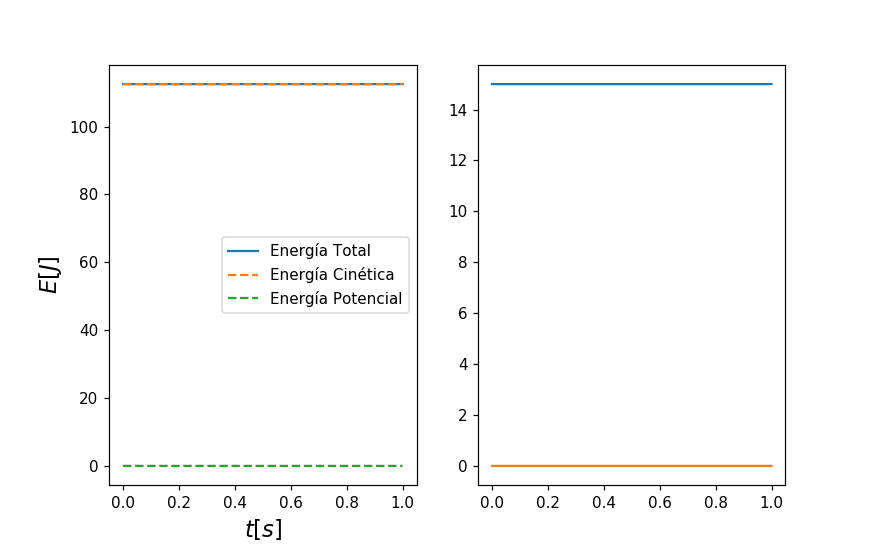

In [30]:
EnergiaK = Particles[0].EkVector
EnergiaP = Particles[0].EpVector
EnergiaTotal = Particles[0].EkVector + Particles[0].EpVector

for i in range(1,len(Particles)):
    EnergiaK = np.add(EnergiaK, Particles[i].EkVector)
    EnergiaP = np.add(EnergiaP, Particles[i].EpVector)
    EnergiaTotal = np.add(EnergiaTotal, Particles[i].EkVector + Particles[i].EpVector) 

Momentum = Particles[0].GetMomentumVector()

for i in range(1,len(Particles)):
    Momentum = np.add(Momentum, Particles[i].GetMomentumVector()) 

fig1 = plt.figure(figsize=(8,5))
ax1 = fig1.add_subplot(1,2,1)
ax2 = fig1.add_subplot(1,2,2)

ax1.plot(t,EnergiaTotal, label='Energía Total')
ax1.plot(t,EnergiaK,'--',label='Energía Cinética')
ax1.plot(t,EnergiaP,'--',label='Energía Potencial')
ax1.set_xlabel(r'$t[s]$',fontsize=15)
ax1.set_ylabel(r'$E[J]$',fontsize=15)

#ax1.set_yscale('log')
ax1.legend(loc=0)

plt.savefig('EnergiaPotencial.pdf')

ax2.plot(t,Momentum[:,0])
ax2.plot(t,Momentum[:,1])

#ax1.plot(t,Particles[0].EkVector)
#ax1.plot(t,Particles[1].EkVector)

In [31]:
array2D = np.zeros((len(t),2))
array2D[:,0] = t
array2D[:,1] = EnergiaP[:,0]
np.savetxt('EnergiaPotencialGas2D.txt',array2D)

In [32]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
    
    Newt = []
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [33]:
redt = ReduceTime(t,100)

In [34]:
#plt.plot(Particles[0].GetPositionVector()[:,0],Particles[0].GetPositionVector()[:,1])
#plt.plot(Particles[0].GetReducePosition()[:,0],Particles[0].GetReducePosition()[:,1],'.')
#plt.show()

<IPython.core.display.Javascript object>


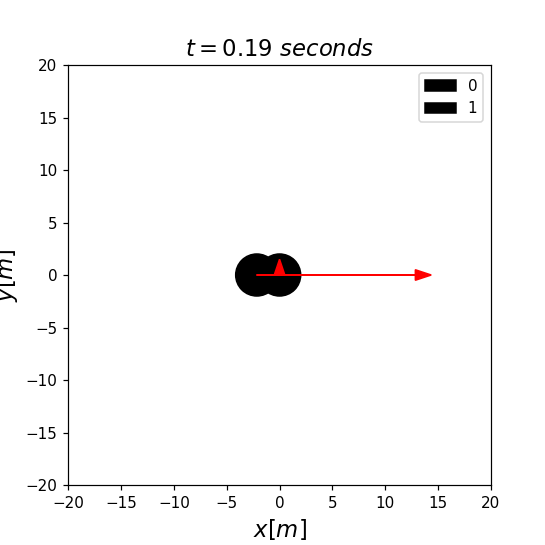

In [35]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
   
def init():
    ax.set_xlabel(r'$x[m]$',fontsize=15)
    ax.set_ylabel(r'$y[m]$',fontsize=15)
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

Colors = ['y','r','k']

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
        
    
    j = 0
    for p in Particles:
        x = p.GetReducePosition()[i,0]
        y = p.GetReducePosition()[i,1]
        
        vx = p.GetReduceVelocity()[i,0]
        vy = p.GetReduceVelocity()[i,1]
    
        
       # circle = plt.Circle((x,y),p.GetR(),fill=True,color=Colors[j],label=str(j))
        circle = plt.Circle((x,y),p.GetR(),fill=True,color='k',label=str(j))
        plot = ax.add_patch(circle)
        plot = ax.arrow(x,y,vx,vy,color='r',head_width=1.0)
        j += 1
        
    plot = ax.legend(loc=1)
            
    return plot
    
Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

In [13]:
Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=50, metadata=dict(artist='Me'))
#Animation.save('Billar.mp4', writer=writer_)

In [14]:
writergif = anim.PillowWriter(fps=30) 
#Animation.save('FallingBall.gif', writer=writergif)

In [15]:
def RemoveParticles(Particles):
    print('--- Deleting Particles---')
    for i in range(len(Particles)):
        if len(Particles) > 0:
            del Particles[-1]

In [16]:
#RemoveParticles(Particles)